<a href="https://colab.research.google.com/github/JimmyGPB/homebound/blob/main/Homebound_Spatial_Temporal_prediction_missing_persons_Ecuador.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/MyDrive/Colab Notebooks

/content/drive/MyDrive/Colab Notebooks


# Importing libraries

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib import dates as mdates
from tabulate import tabulate

# libraries to use for preprocesing the data
from numpy import unicode_
import pandas as pd
import numpy as np

# Libraries used to create the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from keras.src.engine.input_layer import InputLayer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

# Plotting data


Variables, clases y tipos de datos:
+-------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------+
| Variable                | Clases                                                                                                                                                                             

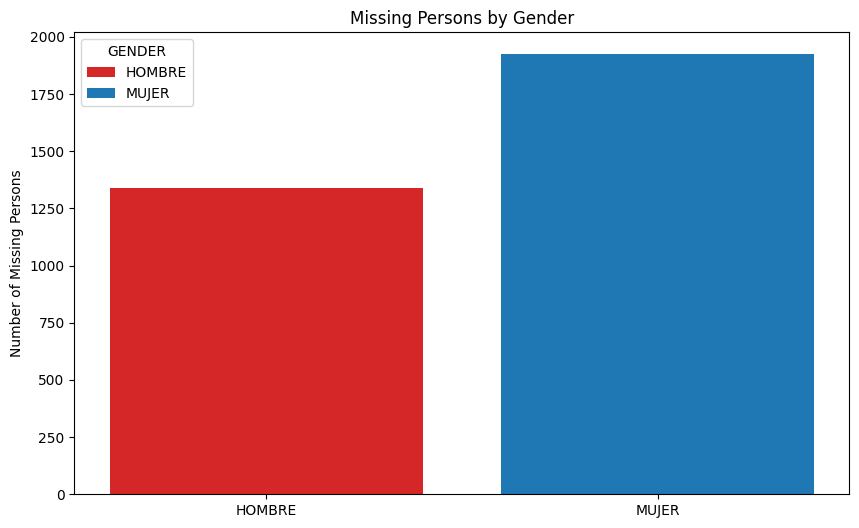

In [ ]:
class MissingPersonsAnalyzer:
    def __init__(self, file_path):
              """
        Constructor for the MissingPersonsAnalyzer class.

        Parameters:
        - file_path (str): Path to the CSV file containing missing persons data.
        """
        self.data = pd.read_csv(file_path, encoding='latin1', sep=";")

    def display_summary_statistics(self):
        """
        Display summary statistics of the missing persons dataset, including variable names, unique classes,
        and data types. Also prints the minimum and maximum age, and the number of missing persons by gender.
        """

        print("\nVariables, clases y tipos de datos:")
        headers = ["Variable", "Clases", "Tipo de Dato"]
        rows = []
        excluded_columns = ['Latitud', 'Longitud', 'Edad Aprox.', 'Fecha Localización', 'Fecha Desaparición']

        for column in self.data.columns:
            if column in excluded_columns:
                continue

            unique_classes = set(self.data[column]) if self.data[column].dtype == 'O' else None
            data_type = self.data[column].dtype
            rows.append([column, unique_classes, data_type])

        print(tabulate(rows, headers=headers, tablefmt="pretty", colalign=("left", "left", "left"), numalign="center", showindex=False))
        # Imprimir edad mínima y máxima
        print(f"\nEdad Mínima: {self.data['Edad Aprox.'].min()}")
        print(f"Edad Máxima: {self.data['Edad Aprox.'].max()}")
        # Imprimir número de mujeres y hombres desaparecidos
        print(f"\nNúmero de mujeres desaparecidas: {self.data[self.data['Sexo'] == 'MUJER'].shape[0]}")
        print(f"Número de hombres desaparecidos: {self.data[self.data['Sexo'] == 'HOMBRE'].shape[0]}")

    def find_province_with_most_disappearances(self):
        """
        Find the province with the most disappearances each month until June and display the results.
        """
        # Encontrar la provincia con más desapariciones por mes hasta junio
        self.data['Fecha Desaparición'] = pd.to_datetime(self.data['Fecha Desaparición'], format='%d/%m/%Y', errors='coerce')
        self.data['Month'] = self.data['Fecha Desaparición'].dt.month
        data_until_june = self.data[self.data['Month'] <= 6]
        monthly_counts = data_until_june.groupby(['Month', 'Provincia']).size().unstack()
        province_with_most_disappearances = monthly_counts.idxmax(axis=1).reset_index()
        province_with_most_disappearances.columns = ['Mes', 'Provincia con más desapariciones']
        month_names = {1: 'Enero', 2: 'Febrero', 3: 'Marzo', 4: 'Abril', 5: 'Mayo', 6: 'Junio'}
        province_with_most_disappearances['Mes'] = province_with_most_disappearances['Mes'].map(month_names)
        province_with_most_disappearances['Cantidad de Desaparecidos'] = monthly_counts.max(axis=1).values
        print("\nProvincia con más desapariciones por mes hasta junio:")
        print(province_with_most_disappearances)

    def age_data_transformation(self):
        """
        Transform age data by setting age values to None for the opposite gender.
        Returns separate DataFrames for men and women.

        Returns:
        - age_men (pd.DataFrame): Transformed age data for men.
        - age_women (pd.DataFrame): Transformed age data for women.
        """

        # Transformación de datos de edad
        age_men = self.data.filter(items=['Edad Aprox.', 'Sexo'])
        age_women = self.data.filter(items=['Edad Aprox.', 'Sexo'])
        cond = age_men['Sexo'] == 'MUJER'
        age_men.loc[cond, 'Edad Aprox.'] = None
        cond = age_women['Sexo'] == 'HOMBRE'
        age_women.loc[cond, 'Edad Aprox.'] = None
        return age_men, age_women

    def date_data_transformation(self):
        """
        Transform date data by setting date values to None for the opposite gender.
        Returns separate DataFrames for men and women.

        Returns:
        - fecha_men (pd.DataFrame): Transformed date data for men.
        - fecha_women (pd.DataFrame): Transformed date data for women.
        """

        # Transformación de datos de fecha
        fecha_men = self.data.filter(items=['Fecha Desaparición', 'Sexo'])
        fecha_women = self.data.filter(items=['Fecha Desaparición', 'Sexo'])
        cond = fecha_women['Sexo'] == 'HOMBRE'
        fecha_women.loc[cond, 'Fecha Desaparición'] = None
        cond = fecha_men['Sexo'] == 'MUJER'
        fecha_men.loc[cond, 'Fecha Desaparición'] = None
        return fecha_men, fecha_women

    def create_bar_chart(self):
        """
        Create a bar chart showing the number of missing persons by gender.
        """
        # Crear gráfico de barras
        fig, ax = plt.subplots(figsize=(10, 6))
        counts = [self.data[self.data['Sexo'] == 'HOMBRE']['Sexo'].count(), self.data[self.data['Sexo'] == 'MUJER']['Sexo'].count()]
        bar_labels = ['HOMBRE', 'MUJER']
        bar_colors = ['tab:red', 'tab:blue']
        ax.bar(bar_labels, counts, label=bar_labels, color=bar_colors)
        ax.set_ylabel('Number of Missing Persons')
        ax.set_title('Missing Persons by Gender')
        ax.legend(title='GENDER')
        plt.show()

    def scatter_plot(self, age_men, age_women):

        """
        Create a scatter plot showing the relationship between age and date of disappearance for men and women.

        Parameters:
        - age_men (pd.DataFrame): Transformed age data for men.
        - age_women (pd.DataFrame): Transformed age data for women.
        """
        # Crear gráfico de dispersión
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.scatter(self.data['Fecha Desaparición'], age_women['Edad Aprox.'], color='blue', alpha=0.5)
        ax.scatter(self.data['Fecha Desaparición'], age_men['Edad Aprox.'], color='red', alpha=0.5)
        custom = [Line2D([], [], marker='.', color=i, linestyle='None', markersize=15, alpha=0.7) for i in ["red", "blue"]]
        ax.legend(custom, ["HOMBRE", "MUJER"])
        ax.xaxis.set_minor_locator(mdates.MonthLocator())
        ax.xaxis.set_minor_formatter(mdates.DateFormatter('%B'))
        plt.setp(ax.xaxis.get_minorticklabels(), rotation=0)
        ax.xaxis.set_major_locator(mdates.YearLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter("January"))
        plt.show()

    def age_histogram(self):
        """
        Create a histogram of the age distribution for missing persons aged 10 to 20, separated by gender.
        Also print the percentage of men and women in the age range.
        """

        # Crear histograma de edad
        data_filtered = self.data[(self.data['Edad Aprox.'] >= 10) & (self.data['Edad Aprox.'] <= 20)]
        plt.figure(figsize=(10, 6))
        plt.hist(data_filtered[data_filtered['Sexo'] == 'MUJER']['Edad Aprox.'], bins=10, alpha=0.5, color='blue', label='Mujeres')
        plt.hist(data_filtered[data_filtered['Sexo'] == 'HOMBRE']['Edad Aprox.'], bins=10, alpha=0.5, color='red', label='Hombres')
        plt.xlabel('Age')
        plt.ylabel('Count')
        plt.title('Age Histogram of Missing Persons (Ages between 10 and 20 years)')
        plt.legend()
        plt.grid(True)

        # Imprimir porcentaje de mujeres y hombres en el rango de edad (10-20 años)
        total_mujeres = len(data_filtered[data_filtered['Sexo'] == 'MUJER'])
        total_hombres = len(data_filtered[data_filtered['Sexo'] == 'HOMBRE'])
        porcentaje_mujeres = (total_mujeres / (total_mujeres + total_hombres)) * 100
        porcentaje_hombres = (total_hombres / (total_mujeres + total_hombres)) * 100
        print(f"\nPorcentaje de mujeres en el rango de edad (10-20 años): {porcentaje_mujeres:.2f}%")
        print(f"Porcentaje de hombres en el rango de edad (10-20 años): {porcentaje_hombres:.2f}%")
        plt.show()

    def line_plot(self, total_men, total_women):
        """
        Create a line plot showing the number of missing persons over time, separated by gender.

        Parameters:
        - total_men (pd.DataFrame): Counts of missing persons by date for men.
        - total_women (pd.DataFrame): Counts of missing persons by date for women.
        """
        # Crear gráfico de línea
        fig, ax = plt.subplots(figsize=(10, 6))
        plt.plot(total_men, color="red")
        plt.plot(total_women, color="blue")
        plt.title('Number of Missing Persons by Date and Gender in Ecuador, Year 2023', fontsize=20)
        plt.xlabel('Date', fontsize=13)
        plt.ylabel('Number of Missing Persons', fontsize=13)
        plt.legend(["HOMBRE", "MUJER"])
        ax.xaxis.set_minor_locator(mdates.MonthLocator())
        ax.xaxis.set_minor_formatter(mdates.DateFormatter('%B'))
        plt.setp(ax.xaxis.get_minorticklabels(), rotation=0)
        ax.xaxis.set_major_locator(mdates.YearLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter("January"))
        plt.show()

    def analyze_and_visualize(self):
         """
        Analyze and visualize missing persons data based on user-selected options.
        Obtains necessary data for visualization from various methods within the class.
        """

        # Llamar a las funciones de análisis y visualización
        self.display_summary_statistics()
        self.find_province_with_most_disappearances()
        age_men, age_women = self.age_data_transformation()
        fecha_men, fecha_women = self.date_data_transformation()

        # Menú para seleccionar el gráfico
        print("\nSeleccione el tipo de gráfico:")
        print("1. Gráfico de Barras (Número de personas desaparecidas por género)")
        print("2. Gráfico de Dispersión (Edad vs. Fecha de Desaparición)")
        print("3. Histograma de Edad (Edad de personas desaparecidas en rango de 10 a 20 años)")
        print("4. Gráfico de Línea (Número de personas desaparecidas por fecha y género)")

        choice = input("Ingrese el número del gráfico que desea visualizar (1-4): ")

        if choice == '1':
            self.create_bar_chart()
        elif choice == '2':
            self.scatter_plot(age_men, age_women)
        elif choice == '3':
            self.age_histogram()
        elif choice == '4':
            self.line_plot(pd.crosstab(index=fecha_men['Fecha Desaparición'], columns="count"),
                           pd.crosstab(index=fecha_women['Fecha Desaparición'], columns="count"))
        else:
            print("Opción no válida. Por favor, ingrese un número del 1 al 4.")

if __name__ == "__main__":
    # Ruta del archivo CSV
    file_path = "/content/mdg_personasdesaparecidas_pm_2023_enero_mayo.csv"
    #file_path = "mdg_personasdesaparecidas_pm_2023_enero_mayo.csv"
    analyzer = MissingPersonsAnalyzer(file_path)
    analyzer.analyze_and_visualize()


# Preprocessing the data

In [ ]:

def data_ordered_days(data, all_dates, date_name, lat_name, lon_name, inLon, inLat):
    """ This function groups all the registers obtained in each day and creates the data for
    the ConvLSTM2D by adding a one in the corresponding coordinates and their surroundings.
    Inputs: data: the data preprocessed with the values of latitude and longitude in
    range from zero to their upper limit; all_dates: an array containing all the dates
    in the dataset sorted by days; date_name: name of the column containing the
    information of the date; lat_name: name of the column containing the information
    of the latitude; lon_name: name of the column containing the information of the
    longitude; inLon: the upper limit of the longitude; inLat: the upper limit of the latitude.
  Outputs: data_for_dates: the resulting data with a value of one in the corresponding
    coordinates and in its surroundings. """

    data_for_dates = []
    num_lat = data.columns.get_loc(lat_name)
    num_lon = data.columns.get_loc(lon_name)

    for date in all_dates:
        date = date[0]
        data_to_append = []
        sub_df = data.loc[data[date_name].between(date, date), :]
        sub_df = sub_df.drop(columns = [date_name])
        sub_data = sub_df.to_numpy()
        sub_data = np.array(sub_data)
        dataInDate = np.zeros((inLon+1, inLat+1))

        for register in sub_data:
            dataInDate[int(register[num_lon]), int(register[num_lat])] = 1
            try:
                dataInDate[int(register[num_lon])   , int(register[num_lat]) +1] = 1
                dataInDate[int(register[num_lon])   , int(register[num_lat]) -1] = 1
                dataInDate[int(register[num_lon]) +1, int(register[num_lat])   ] = 1
                dataInDate[int(register[num_lon]) -1, int(register[num_lat])   ] = 1
                dataInDate[int(register[num_lon]) +1, int(register[num_lat]) +1] = 1     #  ...
                dataInDate[int(register[num_lon]) +1, int(register[num_lat]) -1] = 1     #  ...
                dataInDate[int(register[num_lon]) -1, int(register[num_lat]) +1] = 1     #  ...
                dataInDate[int(register[num_lon]) -1, int(register[num_lat]) -1] = 1
            except: continue

        data_for_dates.append(dataInDate)

    data_for_dates = np.array(data_for_dates)

    return data_for_dates




def ordering_by_date(data, date_name, lat_name, lon_name, date_format='%d/%m/%Y'):
    """ This function sorts by day all the dates in the dataset and preprocess
    the data to have it in a range starting from zero.
    Inputs: data: the data with only the columns of date, latitude and longitude;
    date_name: name of the column containing the information of the date;
    lat_name: name of the column containing the information of the latitude;
    lon_name: name of the column containing the information of the longitude;
    date_format: the format of the date.
    Outputs: data_for_dates: a 3D array (num_samples, longitude_range, latitude_range)
    containing all the registers obtained and sorted by days. """

    all_dates = set(data[date_name])
    all_dates = pd.DataFrame(data=all_dates, columns=[date_name])

    # Later implementation, dealing with missing dates
    all_dates[date_name] = pd.to_datetime(all_dates[date_name], format=date_format)
    all_dates = all_dates.sort_values(by=date_name)
    all_dates[date_name] = all_dates[date_name].dt.strftime('%d/%m/%Y')
    all_dates = np.array(all_dates)

    data[lat_name] = round(data[lat_name], 1)
    data[lon_name] = round(data[lon_name], 1)

    # In this case, we have negative and positive values -> Important to take into consideration when
    # building the LSTM because of the activation function.
    minLat = min(data[lat_name])
    maxLat = max(data[lat_name])
    minLon = min(data[lon_name])
    maxLon = max(data[lon_name])

    data[lat_name] = data[lat_name] - minLat
    data[lon_name] = data[lon_name] * -1
    data[lon_name] = data[lon_name] + maxLon
    data[lat_name] = data[lat_name]*10
    data[lon_name] = (data[lon_name]*10)

    minLatProc = min(data[lat_name])
    maxLatProc = max(data[lat_name])
    minLonProc = min(data[lon_name])
    maxLonProc = max(data[lon_name])
    inLat = int(maxLatProc)
    inLon = int(maxLonProc)

    data_for_dates = data_ordered_days(data, all_dates, date_name, lat_name, lon_name, inLon, inLat)

    return data_for_dates




def data_transform(df, size=7):
    """ This function transforms the data given into the data needed to use in the ConvLSTM2D
    by dividing the data depending on the size of the window given.
    Inputs: df: the dataframe to use, it is a 3D dataframe in order: days, longitud range,
    latitud range; size: the size of the window to divide the data, it is 7 by deafult
    beacuse of the number of days per week.
    Outputs: X_res: A 4D numpy array: days, window size, longitud range, latitud range which
    refers to the features and input; Y_res: A 3D numpy array: days, longitud range,
    latitud range which refers to the output. """

    X = []; Y = []

    for i in range(len(df)-size):
        labels = []
        row = [ a for a in df[i:i+size] ]
        X.append(row)

        label = row.copy()
        labels = label[::-1]
        labels = labels[:-1]
        Y.append(df[i+size])

    X = np.array(X)
    Y = np.array(Y)

    X_res = X.reshape(X.shape[0], size, X.shape[2], X.shape[3], 1)
    Y_res = Y.reshape(X.shape[0], X.shape[2], X.shape[3], 1)

    return X_res, Y_res




def data_division(X1, Y1, train_percentage=0.7):
    """ This function divides the dataset into training, testing, and validation datasets.
    Inputs: X1: dataset to divide into training, testing, validation;
    Y1: Output of the data to use, train_percentage: a number between 0.6 and 0.9
    Outputs: X_train: training dataset, Y_train: training output,
    X_val: validation dataset, Y_val: validation output,
    X_test: testing dataset, Y_test: testing output. """

    val_percentage = (1 - train_percentage)/2

    if (train_percentage > 0.9 or train_percentage < 0.6):
        train_percentage = 0.7
        val_percentage = (1 - train_percentage)/2

    max_len = len(X1)
    train_len = round(max_len * train_percentage)
    val_len = train_len + round(max_len * val_percentage)

    X_train, Y_train = X1[:train_len], Y1[:train_len]
    X_val, Y_val = X1[train_len : val_len], Y1[train_len : val_len]
    X_test, Y_test = X1[val_len:], Y1[val_len:]

    return X_train, Y_train, X_val, Y_val, X_test, Y_test




def preprocess_data(file_name, lat_name, lon_name, date_name, wind_size=7, date_format='%d/%m/%Y', separator=";"):
    """" This function preprocess and creates the dataset needed to use in the ConvLSTM2D.
    Inputs: file_name: the file's name or path containing the data in csv format;
    lat_name: name of the column containing the information of the latitude;
    lon_name: name of the column containing the information of the longitude;
    date_name: name of the column containing the information of the date;
    wind_size: the size of the window to divide the data; date_format: the
    format of the date; separator: the separator of the data in the dataset.
    Outputs: X_train: training dataset; Y_train: training output; X_val: validation
    dataset; Y_val: validation output; X_test: testing dataset; Y_test: testing output;
    data_orig: the original data preprocessed with only containing the columns of latitude,
    longitude and date. """

    data = pd.read_csv(file_name, encoding = 'latin1', sep = separator)

    to_keep = [lat, lon, date]
    to_drop = []
    for column in data.columns:
        if column not in to_keep:
            to_drop.append(column)

    data = data.drop(columns=to_drop)


    for column in [lat, lon]:
        if data[column].dtype == object:
            try:
                data[column] = data[column].astype(float)
            except:
                # Converting the str to float by changing ',' to '.'
                data[column] = data[column].apply(lambda x: float(x.split()[0].replace(',', '.')))

    data_orig = data.copy(deep=True)
    data_for_dates = ordering_by_date(data, date_name, lat_name, lon_name, date_format=date_format)

    X, Y = data_transform(data_for_dates, wind_size)

    X_train, Y_train, X_val, Y_val, X_test, Y_test = data_division(X, Y)

    return X_train, Y_train, X_val, Y_val, X_test, Y_test, data_orig


In [ ]:
lat = "Latitud"; lon = "Longitud"; date = "Fecha Desaparición"
date_format='%d/%m/%Y'
X_train, Y_train, X_val, Y_val, X_test, Y_test, data_orig = preprocess_data("mdg_personasdesaparecidas_pm_2023_enero_mayo.csv", lat, lon, date, date_format='%d/%m/%Y')

X_train.shape, Y_train.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape

((101, 7, 151, 63, 1),
 (101, 151, 63, 1),
 (22, 7, 151, 63, 1),
 (22, 151, 63, 1),
 (21, 7, 151, 63, 1),
 (21, 151, 63, 1))

# Creating the model

In [ ]:
def create_model(X_train, filt=14, num_layers=10, data_form='channels_last', kernSize=(5,5),
                 act='tanh', dropout_percentage=0.0, wind_size=7, summary=True):
    """ This function creates the model using ConvLSTM2D layers, BatchNormalization layers and a Conv2D layer
    Inputs: X_train: the training dataset (5 dimentional dataset), it is used to obtain the dimmentions of the
    input for the ConvLSTM2D layer; filt: number of filters to use (number bigger than 0); num_layers: the
    number of ConvLSTM2D layers to create; data_form: the format of the data (channels_last or channels_first);
    kernSize: the size of the convolution window it must be a tuple of two numbers (example: (5,5)); act: the
    activation function to use; dropout_percentage: the percentage of dropout to apply; wind_size: a number
    refering to the window size used in the dataset; summary: boolean to show the summary of the model.
    Outputs: model: the model created. """

    if filt < 1: filt = 14
    if num_layers < 1: num_layers = 10

    model = Sequential()
    model.add(InputLayer((wind_size, X_train.shape[2], X_train.shape[3], 1))) # is X = X1 ?
    model.add(BatchNormalization())

    for _ in range(num_layers-1):

        model.add(ConvLSTM2D(
            filters=filt, kernel_size=kernSize, padding='same', return_sequences=True,
            activation = act, data_format = data_form
        ))
        model.add(BatchNormalization())
        model.add(Dropout(dropout_percentage))

    model.add(ConvLSTM2D(
        filters=4, kernel_size=kernSize, padding='same', return_sequences=False,
        activation = act, data_format = data_form
    ))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_percentage))

    # This layer results on an otput shape of 1
    model.add(Conv2D(
        filters=1, kernel_size=(3,3), activation='hard_sigmoid', padding='same',
        data_format = data_form
    ))
    model.add(BatchNormalization())

    if summary == True:
        print(model.summary())

    return model




def train_model(model, X_train, Y_train, X_val, Y_val, num_patience=10, num_epochs=250,
                num_batch=20, save_model=True, model_name="Model"): # num_batch=7 ?
    """ This function trains the model created before
    Inputs: model: a model; X_train: the training dataset; Y_train: the output of the traininig
    dataset; X_val: the validation dataset; Y_val: the output of the validation dataset;
    num_patience: the number of epochs of patience used for early stopping; num_epochs: the number
    of epochs used to train the model; num_batch: the size of the batch; save_model: boolean to save
    or not the model; model_name: the name to save the model.
    Outputs: model: the model trained; history: the history related to the training of the model at
    every epoch, here we have the history of the metrics in every epoch of the training. """

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=num_patience),
    ]
    cp = ModelCheckpoint('PL/model/',save_best_only=True)

    model.compile(loss='binary_crossentropy', optimizer='adam',
              metrics=[RootMeanSquaredError(), 'MSE', 'mean_absolute_error'])

    history = model.fit(X_train, Y_train,
                    validation_data = (X_val, Y_val),
                    epochs=num_epochs,
                    batch_size = num_batch,
                    callbacks = [cp, callbacks]
                    )

    if save_model == True:
        model_name += ".keras"
        model.save(model_name)

    return model, history




def plot_trainingLoss(history):
    """ This function plots the loss and val loss by epochs of the training of the model
    Input: the history related to the training of the model at every epoch. """

    pd.DataFrame(history.history)[['loss', 'val_loss' ]].plot(figsize=(10, 6))
    plt.grid(True)
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.show()


In [ ]:
model = create_model(X_train)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (Batch  (None, 7, 151, 63, 1)     4         
 Normalization)                                                  
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, 7, 151, 63, 14)    21056     
                                                                 
 batch_normalization_1 (Bat  (None, 7, 151, 63, 14)    56        
 chNormalization)                                                
                                                                 
 dropout (Dropout)           (None, 7, 151, 63, 14)    0         
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 7, 151, 63, 14)    39256     
                                                                 
 batch_normalization_2 (Bat  (None, 7, 151, 63, 14)    5

In [ ]:
model, history = train_model(model, X_train, Y_train, X_val, Y_val)

Epoch 1/250
6/6 [==============================] - 88s 8s/step - loss: 1.5856 - root_mean_squared_error: 0.9954 - MSE: 0.9909 - mean_absolute_error: 0.7317 - val_loss: 0.6446 - val_root_mean_squared_error: 0.4751 - val_MSE: 0.2258 - val_mean_absolute_error: 0.4751
Epoch 2/250
6/6 [==============================] - 37s 7s/step - loss: 1.0495 - root_mean_squared_error: 0.9966 - MSE: 0.9932 - mean_absolute_error: 0.7758 - val_loss: 0.6025 - val_root_mean_squared_error: 0.4526 - val_MSE: 0.2048 - val_mean_absolute_error: 0.4524
Epoch 3/250
6/6 [==============================] - 36s 7s/step - loss: 0.8989 - root_mean_squared_error: 0.9901 - MSE: 0.9803 - mean_absolute_error: 0.7735 - val_loss: 0.5639 - val_root_mean_squared_error: 0.4311 - val_MSE: 0.1858 - val_mean_absolute_error: 0.4308
Epoch 4/250
6/6 [==============================] - 36s 7s/step - loss: 0.7903 - root_mean_squared_error: 0.9885 - MSE: 0.9772 - mean_absolute_error: 0.7477 - val_loss: 0.5253 - val_root_mean_squared_error:

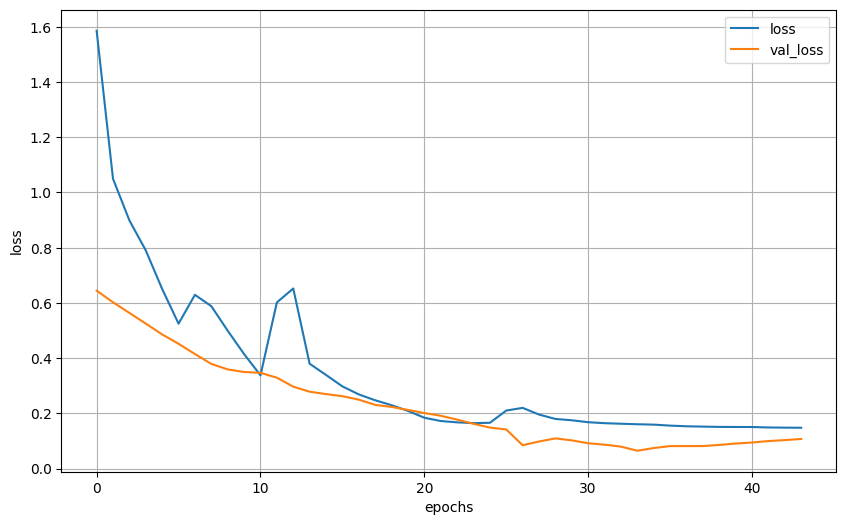

In [ ]:
plot_trainingLoss(history)

# Model: Uses channels last, shape=(None, 7, 151, 63, 1)
filt = 14

data_form = 'channels_last'

kernSize = (5,5)

precision=1.85

activation = 'tanh'

window size = 7

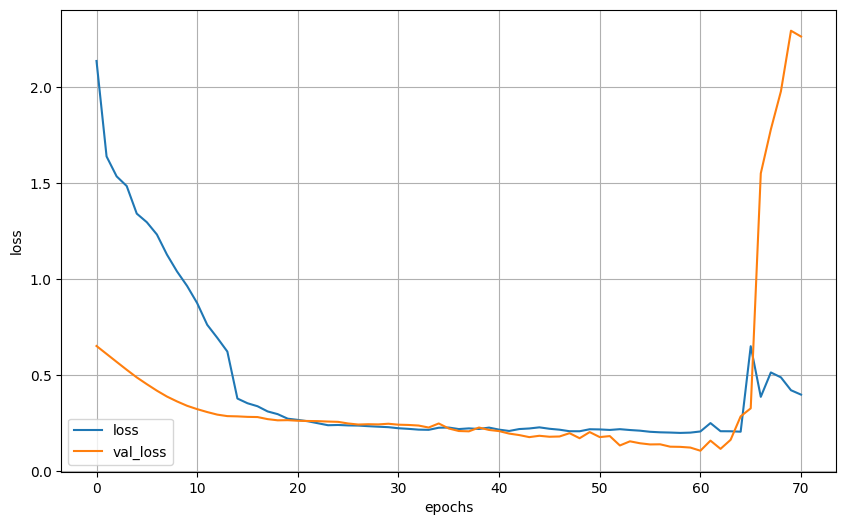

In [ ]:
plot_trainingLoss(history)

# Testing the model

In [ ]:
def test_model(model_path, data, lat_name, lon_name, date_name, X_test, Y_test,
               date_format='%d/%m/%Y', diaTest=1, precision=0.15, plot_test=True):
    """ This function is used to tests the model, by predicting the new values of the day
    specified by the user, it uses the testing dataset, to better understand the predictions
    this function creates a plot where the predicted and realvalues are presented.
    Inputs: model_path: the path of the model; data: the data containing the columns latitude,
    longitude and date; lat_name: name of the column containing the information of the latitude;
    lon_name: name of the column containing the information of the longitude; date_name: name
    of the column containing the information of the date; X_test: the testing dataset; Y_test: the
    output of the testing dataset; date_format: the format of the date; diaTest: the number of the
    day to be tested; precision: a float number with the precision to use to discart the data with
    less value than the precision; plot_test: a boolean to plot or not the predicted and real values.
    Outputs: true_val: an array containing the real values; pred_val: an array containing the result
    of the predicted values. """

    inLon = X_test.shape[2] -1
    inLat = X_test.shape[3] -1

    all_dates = set(data[date_name])
    all_dates = pd.DataFrame(data=all_dates, columns=[date_name])
    all_dates[date_name] = pd.to_datetime(all_dates[date_name], format=date_format)
    all_dates = all_dates.sort_values(by=date_name)
    all_dates[date_name] = all_dates[date_name].dt.strftime('%d/%m/%Y')
    all_dates = np.array(all_dates)

    minLat = min(data[lat_name])
    maxLat = max(data[lat_name])
    minLon = min(data[lon_name])
    maxLon = max(data[lon_name])
    minLat = round(minLat, 1)
    maxLon = round(maxLon, 1)

    # Loading the model
    model = load_model(model_path)

    new_val = X_test[diaTest].reshape((1, X_test.shape[1], X_test.shape[2], X_test.shape[3], 1))
    value_predict = model.predict(new_val)
    value_predict = value_predict.reshape(151, 63)

    latPred = []; lonPred = []
    for i in range (inLat):
      for j in range(inLon):
        if abs(value_predict[j][i]) > precision:
          latPred.append( (i/10) + minLat )
          lonPred.append( ((j/10) - maxLon)*-1 ) # Review the use of negative value, maybe it can be automated ?

    pred_val = pd.DataFrame(list(zip(latPred, lonPred)), columns=[lat_name, lon_name])

    day_test = len(all_dates) - len(X_test) + diaTest
    dayTest = all_dates[day_test][0]
    true_val = data.loc[data[date_name].between(dayTest, dayTest), :]

    fig, ax = plt.subplots()
    ax.scatter(true_val[lat_name], true_val[lon_name] , color='blue', alpha=0.5)
    ax.scatter(pred_val[lat_name], pred_val[lon_name] , color='red', alpha=0.5)
    custom = [ Line2D([], [], marker='.', color=i, linestyle='None', markersize=15,alpha=0.7) for i in ["blue", "red"]]
    ax.legend(custom, ["Real", "Predict"])
    plt.title("Testing the predictions obtained", fontsize=20)
    plt.xlabel("Latitude", fontsize=13)
    plt.ylabel("Longitude", fontsize=13)
    plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
    plt.show()

    return true_val, pred_val

1/1 [==============================] - 4s 4s/step


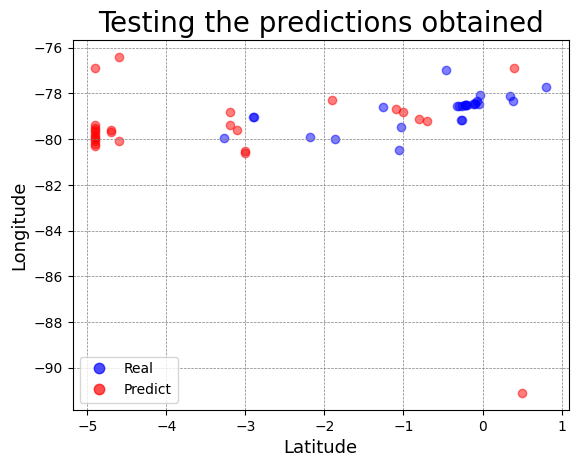

In [ ]:
#model_path = 'Model.keras'
#diaTest = 1; prec = 0.5
model_path = 'TheGoodModel_PL1.keras'
diaTest = 1; prec = 1.85
true_val, pred_val = test_model(model_path, data_orig, lat, lon, date, X_test, Y_test, date_format, diaTest, prec)